# relations entre le niveau de bruit et les mobilités humaines

> Ce Notebook présente lévolution du bruit médian en France depuis lde début de l'épidémie

---
## Importation des modules

In [1]:
%matplotlib inline

import datetime
import os
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import tqdm.notebook as tqdm
import warnings
from scipy import optimize
from scipy.signal import hilbert

from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.client import FDSNNoDataException
from obspy.signal import PPSD

%load_ext autoreload
%autoreload 2
from seismic_noise import *
import seismosocialdistancing

---
## Paramètre initiaux

In [2]:
PPSD_FOLDER  = "/media/flavien/Flavien USB/Stages/noise_data/PPSD"
DRMS_FOLDER  = "/media/flavien/Flavien USB/Stages/noise_data/DRMS"
MSEED_FOLDER = "/media/flavien/Flavien USB/Stages/noise_data/MSEED"
DATA_FOLDER  = "DATA"
freqs = [(0.01, 0.03), (0.1, 0.25), (0.3, 1), (1, 3), (5, 15), (20, 50)] # Bandes de fréquences à étudier
freq = "5.0-15.0"
freq_str = "5.0-15.0"

tStart = "2020-01-01"
tEnd   = "2021-08-01"

# list_stations = ["FR.STR.00.HHZ", "FR.CURIE.00.HHZ", "FR.BRGF.00.HHZ"]
list_stations = np.loadtxt(DATA_FOLDER + "/st_metadata/stations_fr.txt", dtype=str)

In [3]:
tags = {
    "2020-03-17": "Lockdown 1",
    "2020-05-11": "End lockdown",
    "2020-10-30": "Lockdown 2",
    "2020-12-15": "End lockdown + Curfew 20h",
    "2020-12-25": "Christmas",
    "2021-01-01": "New Year",
    "2021-01-16": "Curfew 18h",
    "2021-03-20": "Curfew 19h",
    "2021-04-03": "Lockdown 3",
    "2021-05-03": "End of certificate",
    "2021-05-19": "Curfew 21h + Shops open",
    "2021-06-09": "Curfew 23h + Restaurants open",
    "2021-06-30": "End Curfew"
}
dates_tags = pd.to_datetime(([key for key in tags.keys()]))
desc_tags = [(value) for value in tags.values()]

---
## Médiane à toutes les stations

#### Calcul de la médiane pour chaque station

On calcul les PPSDs sur l'ensemble des périodes d'un mois (1 mois pendant le confinement, 1 mois hors confinement). Toutes les données sont stockées dans le dictionnaire `ppsds`.

In [4]:
tStart = pd.Timestamp(tStart)
tEnd = pd.Timestamp(tEnd)
nDays = (tEnd - tStart).days
dates = pd.date_range(tStart, periods=nDays, freq="D")
dfDates = pd.DataFrame(index=dates)

In [5]:
med_values = []
st_list = []

for j, st_str in tqdm.tqdm(enumerate(list_stations)):
    # name = "{}_{}_{}".format(st_str, str(periods[i][0])[:10], str(periods[i][1])[:10])

    ### Calcul du déplacement RMS de la station
    try:
        dataframe = pd.read_csv("{}/{}.csv".format(DRMS_FOLDER, st_str), index_col=0)
        dataframe.index = pd.to_datetime(dataframe.index)
        dRMS = dataframe.copy()
    except:
        continue
       
    ### Conversion heures locales
    dRMS = dRMS.copy().tz_localize("UTC").tz_convert("Europe/Brussels").tz_localize(None).resample("30Min").mean()
        
    st_list = np.append(st_list, st_str)    
        
    ### On garde les données dans la période temporelle qui nous intéresse
    mask_time = (dRMS.index > tStart) & (dRMS.index <= tEnd)
    dRMS = dRMS.loc[mask_time]
    
    ### Récupération du bruit
    dRMS_med = dRMS[freq].between_time("6:00", "18:00").resample("1D").median()
    dRMS_med = dfDates.join(dRMS_med, how='outer')

    ### Normalisation du bruit
    dRMS_med = dRMS_med[freq].tolist()
    med_values.append(dRMS_med)

150it [00:09, 15.73it/s]


In [6]:
print("Dimensions de la matrice :", np.shape(med_values))

Dimensions de la matrice : (129, 578)


In [7]:
# dRMS_array = med_values

# np.save('sandbaox/dates', dates)
# np.save('sandbox/st_list', st_list)
# np.save('sandbox/dRMS_array', dRMS_array)

#### Calcul de la médiane de toutes les stations

/home/flavien/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


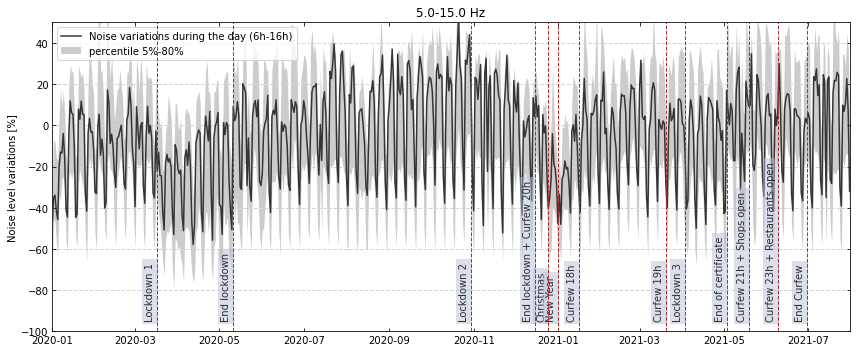

In [8]:
noise_fr = np.zeros(nDays)


for i in range(nDays):

    sublist = list()

    for j in range(np.shape(med_values)[0]):
        sublist = np.append(sublist, med_values[j][i])

    noise_fr[i] = np.nanmedian(sublist)


norm_period = ["2020-01-15", "2020-03-10"]
t1_i = np.where(dates >= pd.Timestamp(norm_period[0]))[0][0]
t2_i = np.where(dates >= pd.Timestamp(norm_period[1]))[0][0]
noise_med = np.nanmedian(noise_fr)
noise_fr = (noise_fr - noise_med)/noise_med*100

color = "#353535"
fig, ax = plt.subplots(figsize=(12, 5))
ax.tick_params(direction="in", which="both", top=True, right=True)
# ax.set_title("Frequency band : {}Hz".format(freq))
ax.plot(dates, noise_fr, color=color, lw=1.5, zorder=3, label="Noise variations during the day (6h-16h)")
plt.ylim(3.5 * np.quantile(noise_fr, 0.05), 5 * np.quantile(noise_fr, 0.95))
ax.set_xlim([dates[0], dates[-1]])
# ax.set_xlabel("Year 2020")
ax.set_ylabel("Noise level variations [%]")

box_txt = dict(boxstyle="square",
               facecolor='#B7C0D8',
               edgecolor='none',
               alpha=0.5)

for n in range(len(dates_tags)):
    t_search = dates_tags[n]
    desc_search = desc_tags[n]
    t_text = t_search - pd.Timedelta("5 days")
    ax.axvline(t_search, ls="--", lw=1, color="#B82A2A", zorder=10)   # Confinement 1
    ax.text(t_text, -95, desc_search,
            color="#2B2B2B", fontsize="medium", rotation=90,
            ha="center", va="bottom",
            bbox=box_txt)   # Confinement 1

med_var = np.zeros(np.shape(med_values))

for i in range(np.shape(med_var)[0]):
    sub_list = med_values[i][:] 
    try:
        med_var[i][:] = (sub_list - np.nanmedian(sub_list))/np.nanmedian(sub_list) * 100
    except:
        med_var[i][:] = sub_list
    
perc_i = list()  # 5%
perc_f = list()  # 80%

for ii in range(np.shape(med_var)[1]):
    sublist = list()
    for i in range(np.shape(med_var)[0]):
        sublist = np.append(sublist, med_var[i][ii])

    perc_i = np.append(perc_i, np.nanquantile(sublist, 0.05))
    perc_f = np.append(perc_f, np.nanquantile(sublist, 0.8))
    
plt.fill_between(dates, perc_i, perc_f,alpha=.25, label="percentile 5%-80%", color=color, lw=0)    
plt.grid(axis="y", color="#D5D5D5", linestyle='--', linewidth=1)
plt.ylim(-100, 50)
plt.legend(loc=2)
plt.title("{} Hz".format(freq_str))
plt.tight_layout()
folder = "RESULTS/FR/all_stations/{}Hz".format(freq_str)
if not os.path.exists(folder): os.makedirs(folder)
plt.savefig("{}/ts_day.png".format(folder), dpi=150)
plt.show()

---
## Relation avec les données de mobilité

In [9]:
data_path = "DATA/google_mobility"
data_country = load_google_mobility(data_path, data_type = "country")

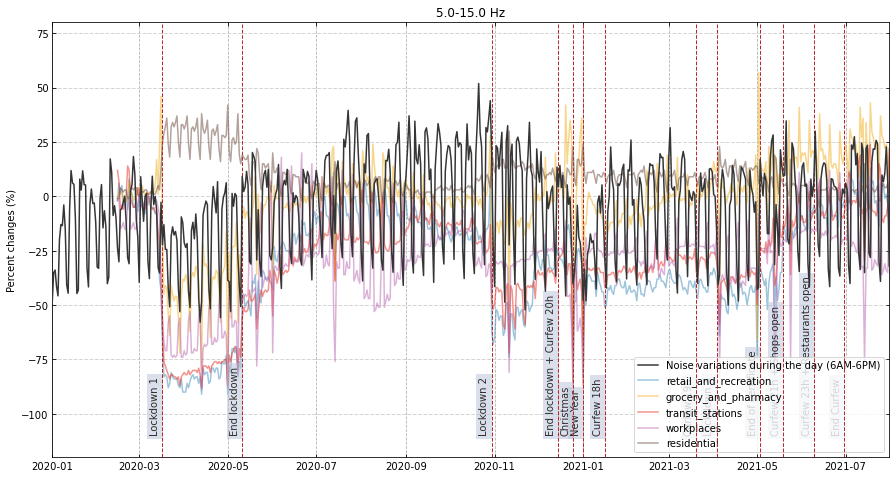

In [ ]:
color = "#353535"
fig, ax = plt.subplots(figsize=(15, 8))
ax.tick_params(direction="in", which="both", top=True, right=True)
ax.plot(dates, noise_fr, color=color, lw=1.5, zorder=20, label="Noise variations during the day (6AM-6PM)")

box_txt = dict(boxstyle="square",
               facecolor='#B7C0D8',
               edgecolor='none',
               alpha=0.5)

for n in range(len(dates_tags)):
    t_search = dates_tags[n]
    desc_search = desc_tags[n]
    t_text = t_search - pd.Timedelta("5 days")
    ax.axvline(t_search, ls="--", lw=1, color="#B82A2A", zorder=10)   # Confinement 1
    ax.text(t_text, -110, desc_search,
            color="#2B2B2B", fontsize="medium", rotation=90,
            ha="center", va="bottom",
            bbox=box_txt)   # Confinement 1

plt.grid(axis="y", color="#D5D5D5", linestyle='--', linewidth=1)
plt.ylim(-100, 50)
plt.title("{} Hz".format(freq_str))



colors = ["#3E8BBA", "#F1AD1A", "#408F2B", "#E6261A", "#B967B0", "#664638"]
plt.plot(data_country.index, data_country["retail_and_recreation"], label="retail_and_recreation", color=colors[0], alpha=0.5)
plt.plot(data_country.index, data_country["grocery_and_pharmacy"], label="grocery_and_pharmacy", color=colors[1], alpha=0.5)
plt.plot(data_country.index, data_country["parks"], label="parks", color=colors[2], alpha=0.5)
plt.plot(data_country.index, data_country["transit_stations"], label="transit_stations", color=colors[3], alpha=0.5)
plt.plot(data_country.index, data_country["workplaces"], label="workplaces", color=colors[4], alpha=0.5)
plt.plot(data_country.index, data_country["residential"], label="residential", color=colors[5], alpha=0.5)

plt.legend()
plt.ylabel("Percent changes (%)")
plt.grid(ls='--')
plt.xlim([dates[0], dates[-1]])
plt.ylim([-120, 80])
plt.show()

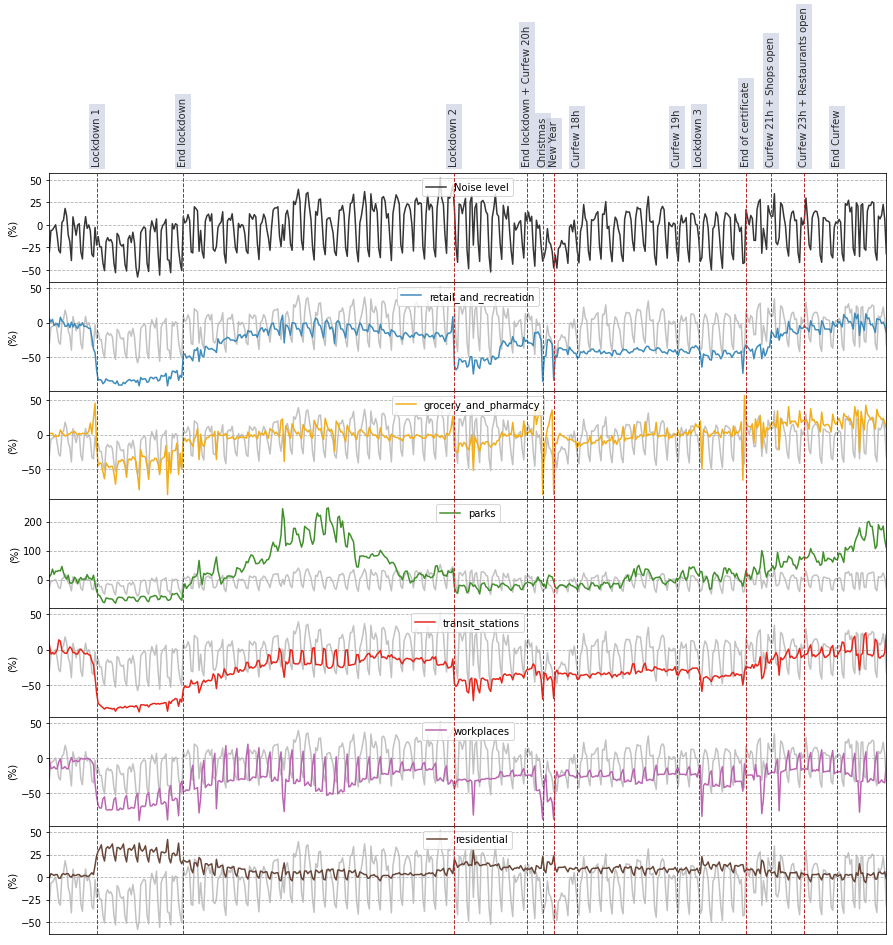

In [70]:
labels = data_country.columns[2:]
N = len(labels)+1

fig = plt.figure(figsize=(15, 2*N))

ax = fig.add_subplot(N,1,1)
ax.plot(dates, noise_fr, color="#353535", label='Noise level')
ax.set_ylabel("(%)")
ax.grid(axis="y", ls='--')
ax.legend(loc=9)  
ax.set_xlim(data_country.index[1], dates[-1])
for n in range(len(dates_tags)):
    t_search = dates_tags[n]
    desc_search = desc_tags[n]
    t_text = t_search
    ax.axvline(t_search, ls="--", lw=1, color="#B82A2A", zorder=10)   # Confinement 1
    ax.text(t_text, 65, desc_search,
        color="#2B2B2B", fontsize="medium", rotation=90,
        ha="center", va="bottom",
        bbox=box_txt)   # Confinement 1
if i+1 != N: ax.axes.xaxis.set_visible(False)

for i, label in enumerate(data_country.columns[2:]):
    ax = fig.add_subplot(N,1,i+2)
    ax.plot(dates, noise_fr, color="#353535", zorder=0, alpha=0.3)
    ax.plot(data_country.index, data_country[label], color=colors[i], label=label)
    ax.set_ylabel("(%)")
    ax.grid(axis="y", ls='--')
    ax.legend(loc=9)  
    ax.set_xlim(data_country.index[1], dates[-1])
    for n in range(len(dates_tags)):
        t_search = dates_tags[n]
        desc_search = desc_tags[n]
        ax.axvline(t_search, ls="--", lw=1, color="#B82A2A", zorder=10)   # Confinement 1
    if i+1 != N: ax.axes.xaxis.set_visible(False)
    
fig.subplots_adjust(hspace=0)
plt.show()

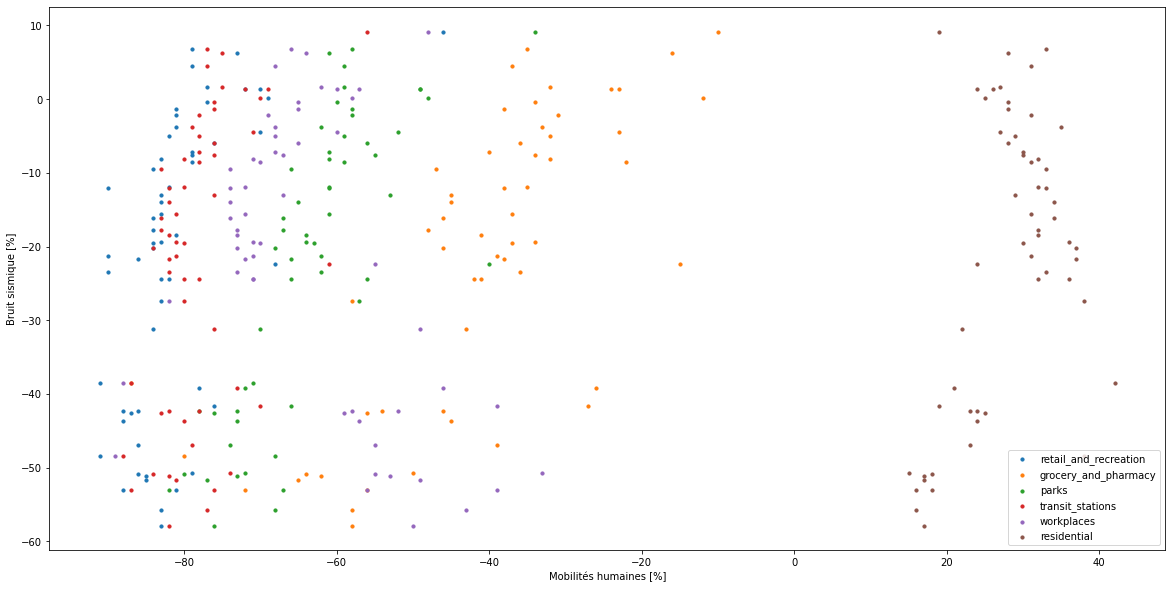

In [54]:
plt.figure(figsize=(20, 10))
mobility_list = ["retail_and_recreation", "grocery_and_pharmacy", "parks", "transit_stations", "workplaces", "residential"]
# mobility_list = ["workplaces"]

# t1 = "2020-02-15" 
# t2 = "2021-07-31"

t1 = "2020-03-17" 
t2 = "2020-05-11"

# Données de bruit
noise_data = noise_fr
noise_data = pd.Series(noise_data, index=dates)
noise_data = noise_data[noise_data.index >= t1]
noise_data = noise_data[noise_data.index <= t2]

for mobility_name in mobility_list:
    # Données de mobilité
    mobility_data = data_country[mobility_name]
    mobility_data = mobility_data[mobility_data.index >= t1]
    mobility_data = mobility_data[mobility_data.index <= t2]
    
    plt.scatter(mobility_data.values, noise_data.values, label=mobility_name, s=10)
    
    
plt.ylabel("Bruit sismique [%]")
plt.xlabel("Mobilités humaines [%]")
plt.legend()
plt.show()